# Bibliotecas e carregamento

In [17]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Carregando objetos
datacube = py4DSTEM.read('/home/ABTLUS/rodrigo.souza/HRTEM/datasets/Fe3O4_15mar/'+ 'calibrated_s.h5')

braggpeaks = datacube.tree('braggvectors')

crystal = py4DSTEM.process.diffraction.Crystal.from_CIF('/home/ABTLUS/rodrigo.souza/HRTEM/datasets/Fe3O4_15mar/metadata/Magnetite.cif')
k_max = 1.0
crystal.calculate_structure_factors(k_max) 

Reading PointListArray: 100%|██████████| 13225/13225 [00:01<00:00, 8214.15PointList/s]
get_structures is deprecated
get_structures is deprecated and will be removed in 2024. Use parse_structures instead.The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().


In [76]:
peaks = []
for i in range(115):
    for j in range(115):
        peaks.append(braggpeaks.cal[i,j].data)
peaks = np.array(peaks, dtype = 'object')
peaks.shape

(13225,)

In [77]:
np.save('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/' + 'braggpeaks', peaks)

In [62]:
braggpeaks.tree

<bound method Node.tree of BraggVectors( A (115, 115)-shaped array of lists of bragg vectors )>

# Automated Crystal Orientation Mapping (ACOM)

In [19]:
# Create an orientation plan
crystal.orientation_plan( # Define arrays de simetrias rotacionais baseadas no point group ou input manual de uma ou mais zonas de eixo.
    zone_axis_range = 'auto', # Range for zone axis orientations. ‘auto’ will use pymatgen to determine the point group symmetry
    angle_step_zone_axis = 1, # Resolução do orientation plan; não colocar >1. Approximate angular step size for zone axis search [degrees]
    angle_step_in_plane = 2, # Baixo suficiente para ganhar corr, alto suficiente para minimizar processamento. Approximate angular step size for in-plane rotation [degrees]
    accel_voltage = 300e3, # In Volts
    calculate_correlation_array=True
    # CUDA=True,
)

Automatically detected point group m-3m,
 using arguments: zone_axis_range = 
[[0 1 1]
 [1 1 1]], 
 fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████| 1596/1596 [00:01<00:00, 800.25 zone axes/s]


Best fit lattice directions: z axis = ([0.433 0.447 0.783]), x axis = ([0.188 0.493 0.849]), with corr value = 3.714
Best fit lattice directions: z axis = ([0.196 0.567 0.8  ]), x axis = ([0.511 0.529 0.678]), with corr value = 2.095
Best fit lattice directions: z axis = ([0.346 0.472 0.811]), x axis = ([0.155 0.31  0.938]), with corr value = 1.23
Best fit lattice directions: z axis = ([0.061 0.259 0.964]), x axis = ([0.256 0.266 0.929]), with corr value = 3.241
Best fit lattice directions: z axis = ([0.057 0.641 0.765]), x axis = ([0.016 0.643 0.766]), with corr value = 3.884
Best fit lattice directions: z axis = ([0.049 0.063 0.997]), x axis = ([0.076 0.332 0.94 ]), with corr value = 4.676
Best fit lattice directions: z axis = ([0.037 0.221 0.975]), x axis = ([0.139 0.674 0.725]), with corr value = 3.516
Best fit lattice directions: z axis = ([0.046 0.631 0.774]), x axis = ([0.415 0.56  0.717]), with corr value = 4.909
Best fit lattice directions: z axis = ([0.049 0.049 0.998]), x ax

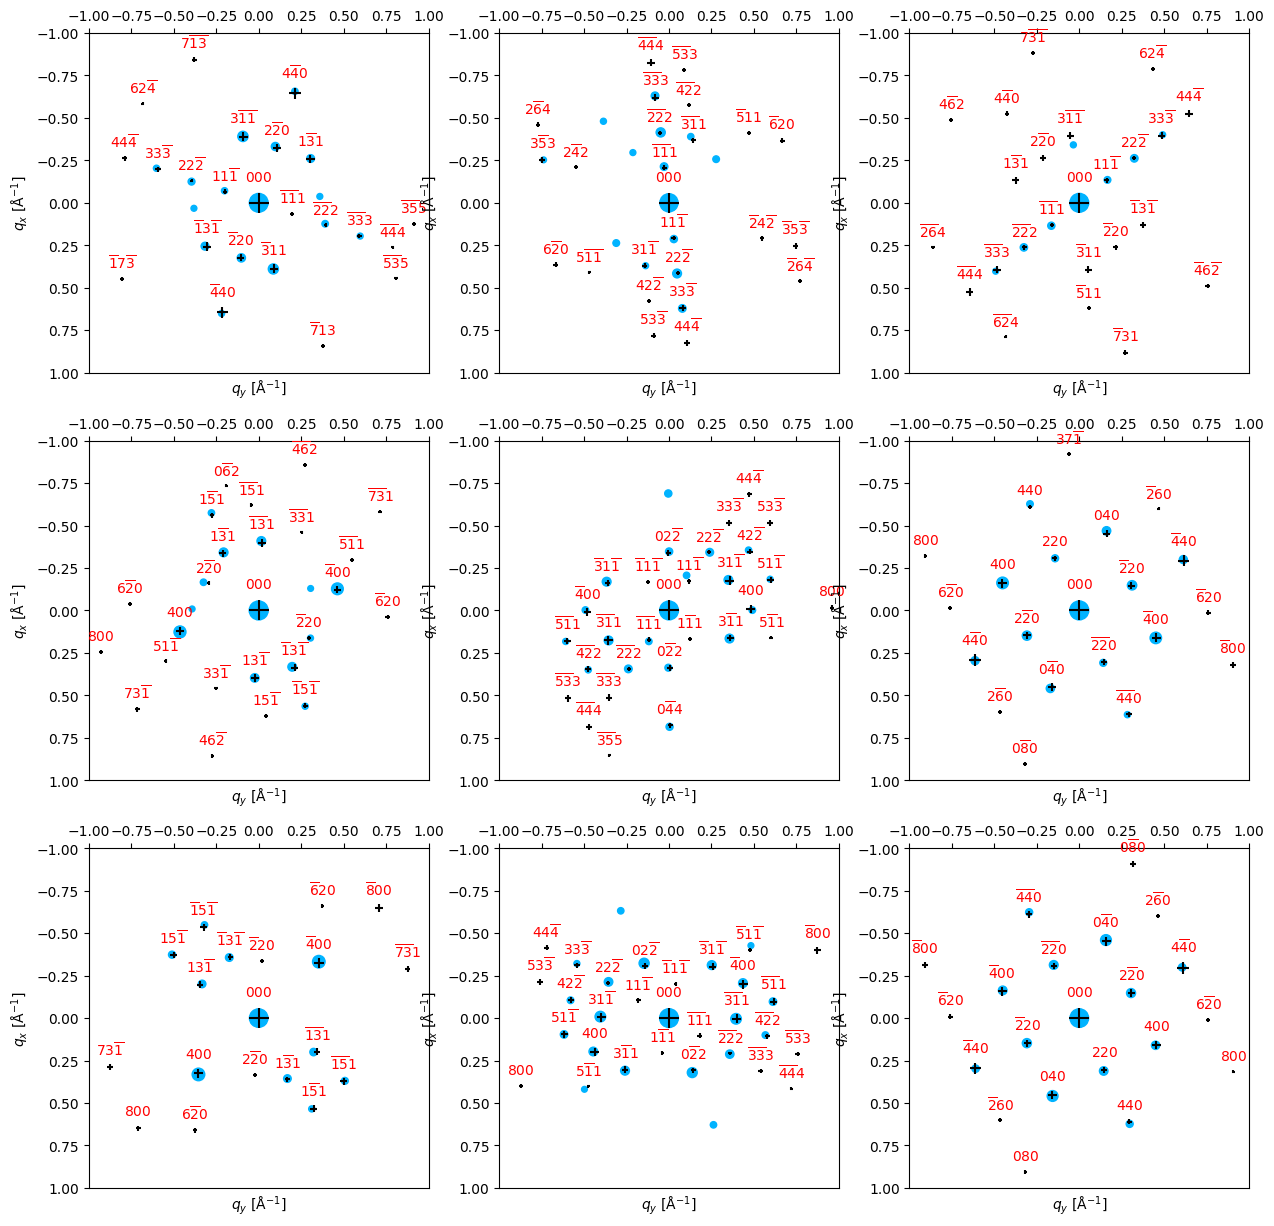

In [71]:
# Test matching on some probe positions
rxs = [0, 112, 0,    0, 0, 0,    0, 7, 0]
rys = [15, 101, 52,  5, 1, 17,  10, 106, 80]

fig,ax = plt.subplots(3,3,figsize=(15,15))
ax = ax.flatten()

# Parâmetros do plot para normalizar o tamanho das esferas de forma relativa. Não é necessário, mas deixa a vizualização mais coerente.
plot_params = {
    'scale_markers': 500, # size scaling for markers
    'scale_markers_compare': 10, # size scaling for markers of comparison
    'plot_range_kx_ky': crystal.k_max, # 2 element numpy vector giving the plot range
    'min_marker_size': 2,
}

# Fit. Abaixo são colocados alguns argumentos de custom fit na forma comentários.
for i in range(9):

    # Find best fit orientations
    orientation  = crystal.match_single_pattern( # Solve for the best fit orientation of a single diffraction pattern.
        bragg_peaks = braggpeaks.cal[rxs[i],rys[i]],
        # plot_corr = True, # Plotar gráfico de corr fit. Não vai funcionar com ax.flatten().
        # num_matches_return = 3, # return these many matches as 3th dim of orient (matrix). Tenta dar mais matches e retornar o melhor
        verbose = True, # Print the fitted zone axes, correlation scores. Quanto maior, melhor.
    )

    peaks_fit = crystal.generate_diffraction_pattern( # Gera um dp de acordo com o fit acima (cruz no gráfico).
        orientation = orientation,
        # ind_orientation = 0, # this input can be used to select a specific orientation. Diretamente relacionado com o num_matches_return acima.
        sigma_excitation_error = 0.02) # Excitation error for the simulated diffraction patterns. Associado com o número total de pixos

    py4DSTEM.process.diffraction.plot_diffraction_pattern(
        bragg_peaks = peaks_fit, # Cruzes
        bragg_peaks_compare = braggpeaks.cal[rxs[i],rys[i]], # Círculos
        **plot_params,
        input_fig_handle = (fig,[ax[i]]),
    )

In [39]:
orientation.family.shape

(1, 3, 3)

In [36]:
orientation.family[0,:,2] # lattice direction: z axis

array([0.04908855, 0.04908855, 0.9975874 ])

In [78]:
orientation.corr # Correlation value. Preciso append isso depois.

array([4.58657313])

Best fit lattice directions: z axis = ([0.037 0.249 0.968]), x axis = ([0.142 0.66  0.738]), with corr value = 2.503


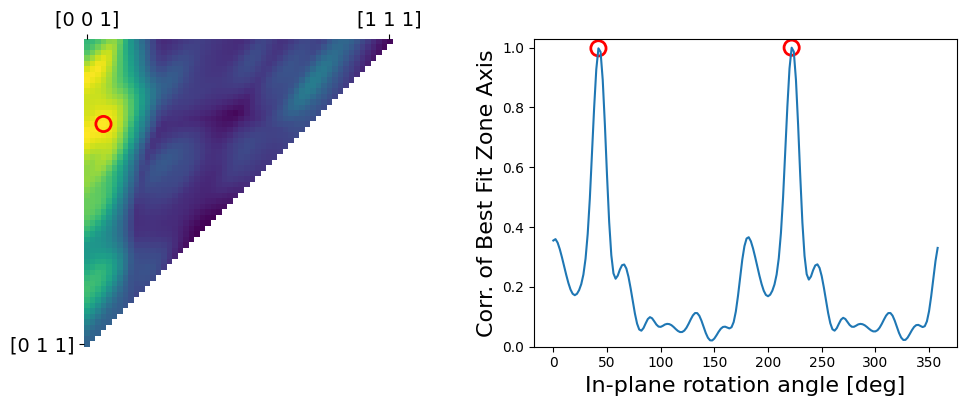

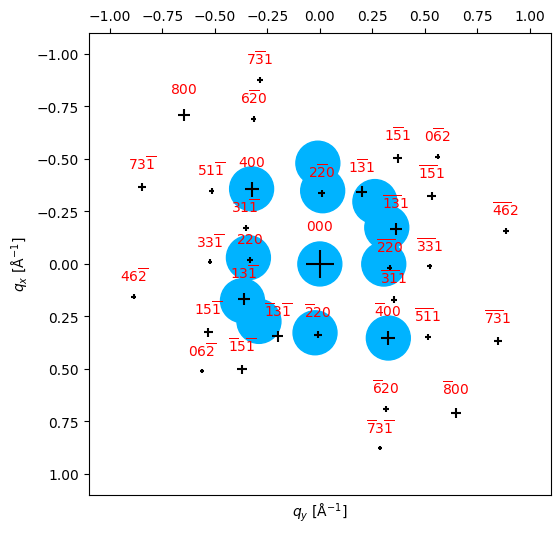

Best fit lattice directions: z axis = ([0.085 0.213 0.973]), x axis = ([0.181 0.485 0.855]), with corr value = 2.548


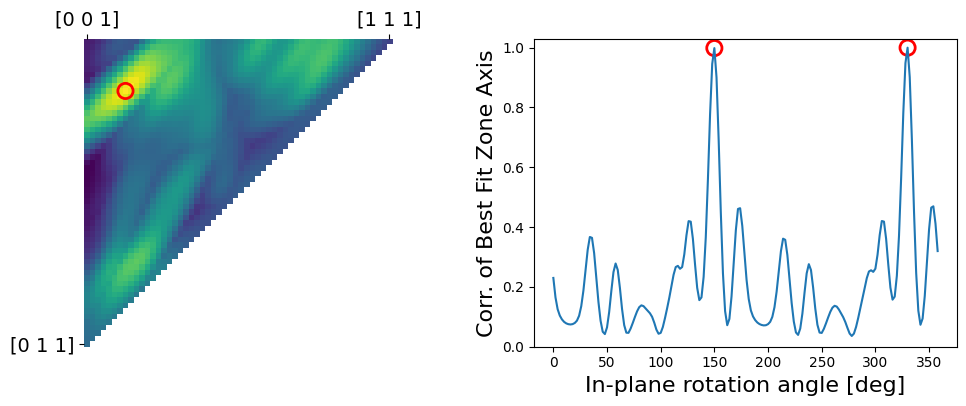

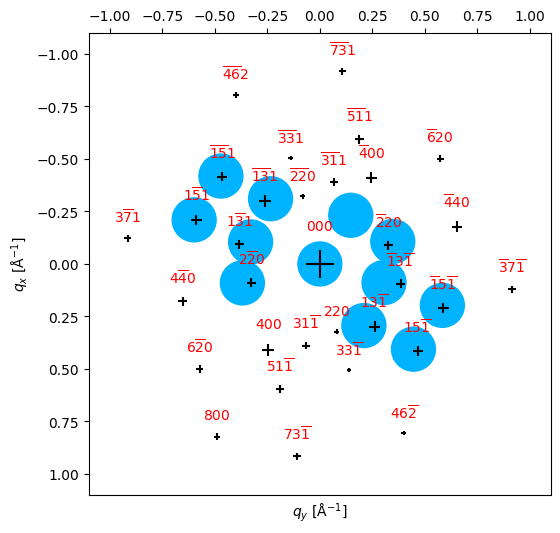

Best fit lattice directions: z axis = ([0.368 0.466 0.805]), x axis = ([0.16  0.439 0.884]), with corr value = 3.263


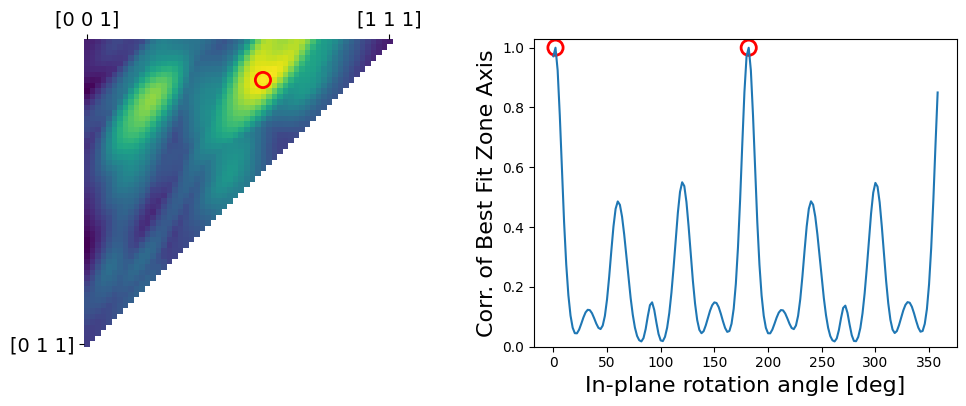

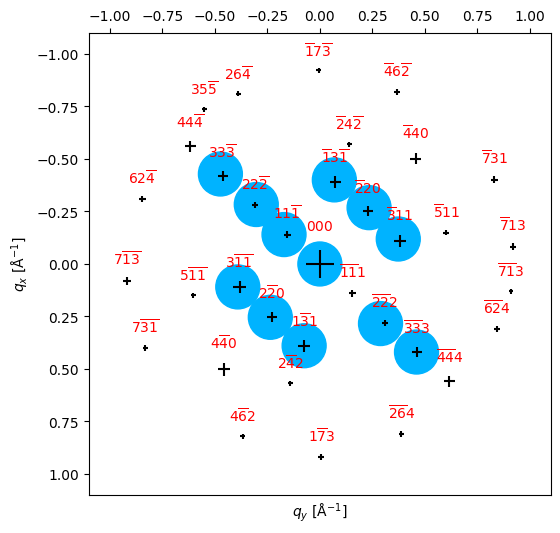

Best fit lattice directions: z axis = ([0.049 0.219 0.974]), x axis = ([0.071 0.094 0.993]), with corr value = 4.19


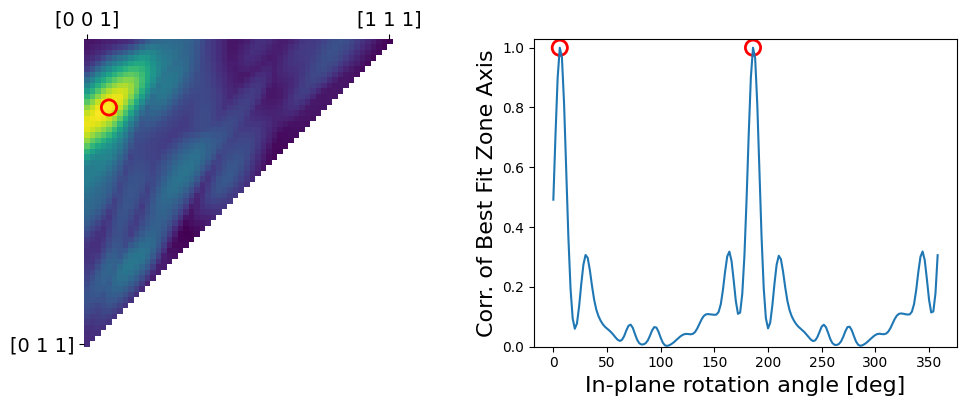

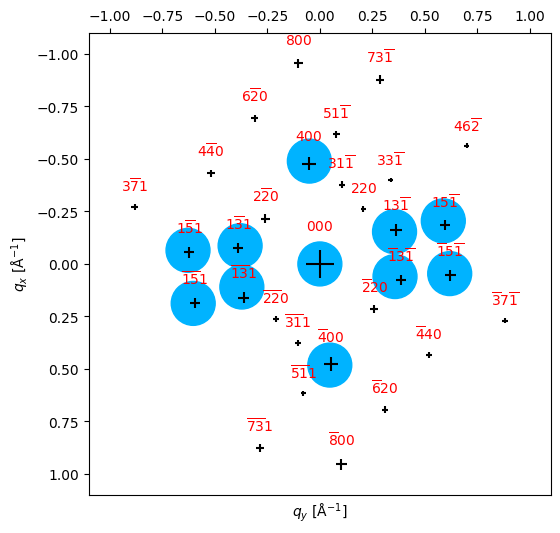

Best fit lattice directions: z axis = ([0.072 0.34  0.938]), x axis = ([0.071 0.345 0.936]), with corr value = 1.617


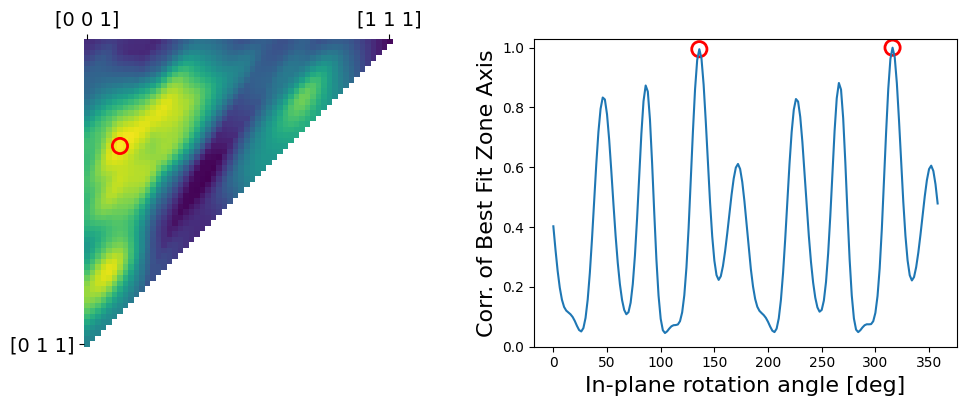

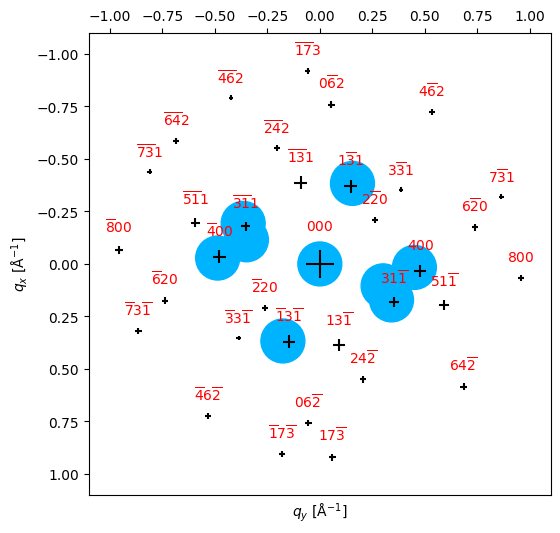

Best fit lattice directions: z axis = ([0.196 0.567 0.8  ]), x axis = ([0.512 0.529 0.676]), with corr value = 2.625


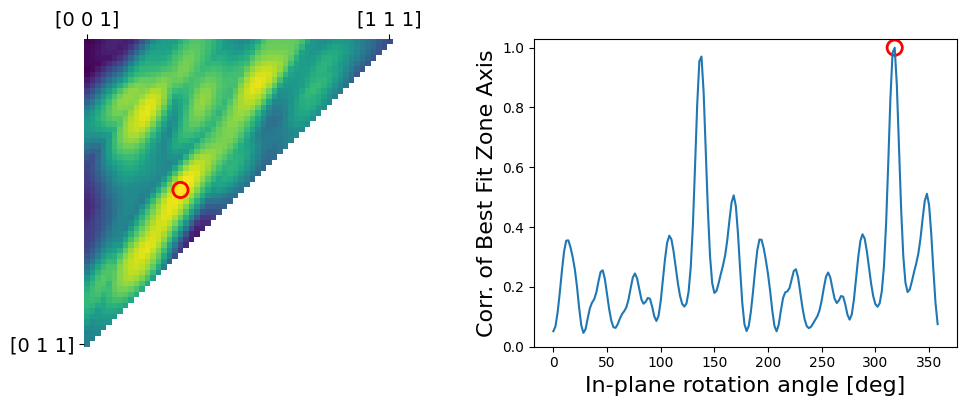

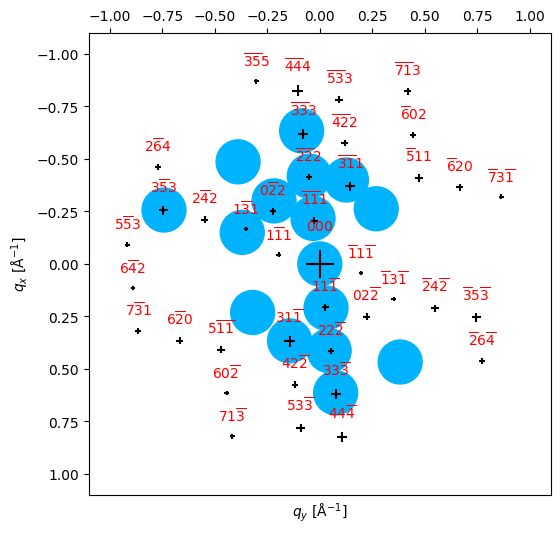

In [8]:
# Plot individual com correlation mapping (opcional)
range_plot = np.array([k_max+0.1,k_max+0.1])

for i in range(6):
    xind = rxs[i]
    yind = rys[i]

    orientation  = crystal.match_single_pattern(
        braggpeaks.cal[xind,yind],
        plot_corr = True, # Argumento do correlation mapping
        # plot_polar = True,
        verbose = True,
    )

    bragg_peaks_fit = crystal.generate_diffraction_pattern(
        orientation,
        ind_orientation = 0,
        sigma_excitation_error = 0.03)

    # plot comparisons
    py4DSTEM.process.diffraction.plot_diffraction_pattern(
        bragg_peaks_fit,
        bragg_peaks_compare=braggpeaks.cal[xind,yind],
        plot_range_kx_ky=range_plot,
        # scale_markers=500, # Condições para plotar os spots em fç da intensidade, como acima (corr value não muda)
        # scale_markers_compare=10,
        # min_marker_size=2,
        scale_markers=1000, 
        scale_markers_compare=4e4,
        min_marker_size=1,


    )

In [21]:
# Tempo execução: 25 min. Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    bragg_peaks_array = braggpeaks,
    # num_matches_return = 1, # return these many matches as 3th dim of orient (matrix)
    # min_number_peaks = 3, # Minimum number of peaks required to perform ACOM matching
)

bragg peaks not rotationally calibrated
Matching Orientations: 100%|██████████| 13225/13225 [29:55<00:00,  7.37 PointList/s]


In [79]:
orientation_map.family.shape

(115, 115, 1, 3, 3)

In [80]:
orientation_map.family[0,15,0,:,2]

array([0.43261736, 0.44666189, 0.78315732])

In [82]:
orientation_map.corr.shape

(115, 115, 1)

In [83]:
orientation_map.corr[0,15]

array([3.71400091])

In [84]:
np.save('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/' + 'orientation_map', orientation_map.family)
np.save('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/' + 'orientation_map_corr', orientation_map.corr)

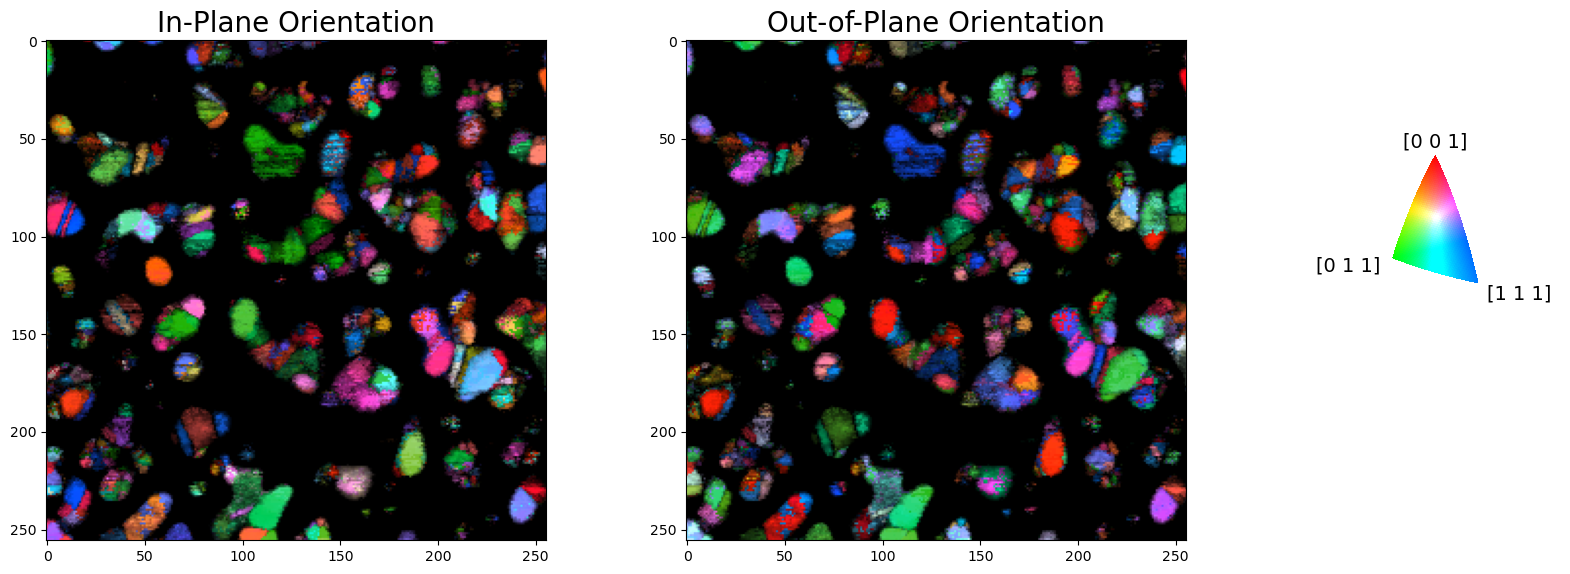

In [123]:
images_orientation = crystal.plot_orientation_maps(
    orientation_map = orientation_map,
    orientation_ind = 0, # Which orientation match to plot if num_matches > 1
    corr_range = np.array([1,4]), # Correlation intensity range for the plot.
    # camera_dist = 10,
    # show_axes = True,
)

# Strain Mapping

In [66]:
strain_map = crystal.calculate_strain(
    bragg_peaks_array = braggpeaks,
    orientation_map = orientation_map,
    rotation_range = np.pi/3, # Maximum rotation range in radians (for symmetry reduction).
#     corr_kernel_size=0.02, # Correlation kernel size - if user does not specify, uses self.corr_kernel_size.
)

# No exemplo "orient_strain_01_WS2..." rotação também não é calibrada.

bragg peaks not rotationally calibrated
Calculating strains: 100%|██████████| 65536/65536 [00:16<00:00, 3992.72 PointList/s]


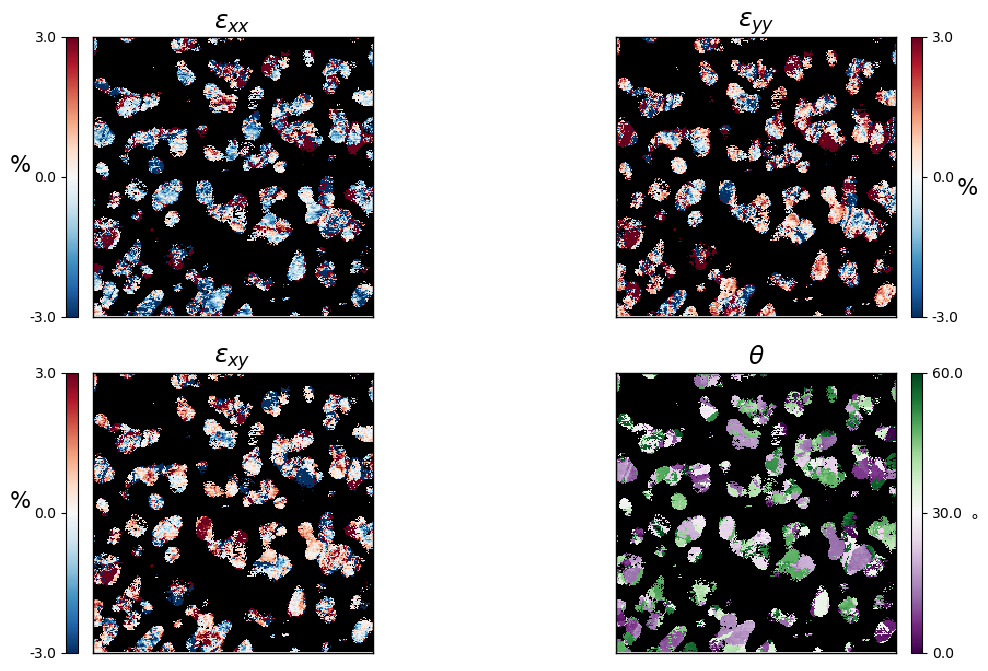

In [138]:
# plot the 4 components of the strain tensor
fig,ax = py4DSTEM.visualize.show_strain(
    data = strain_map,
    vrange_exx = [-3.0, 3.0], # colorbar intensity range for exx
    vrange_theta = [0.0, 60.0], # colorbar intensity range for theta.
    ticknumber = 3, # Number of ticks on colorbars
    # figsize=(6,6),
    returnfig = True
)

# API wholepatternfit

https://py4dstem.readthedocs.io/en/latest/api/process.html#module-py4DSTEM.process.wholepatternfit